# The QR Decomposition 

The $QR$ decomposition is a fundamentally important matrix factorization. It
is straightforward to implement, is numerically stable, and provides the 
basis of several important algorithms. In this lab we explore several 
ways to produce the QR decomposition and implement a few immediate 
applications.

The QR decomposition of a matrix $A$ is a factoration 

$$A =QR$$ 

where $Q$ has orthonormal columns and $R$ is upper triangular. Every $m \times n$
matrix $A$ of rank $n \leq m$ has a QR decomposition, with two main forms. 

- Reduced QR: Q is $m \times n$, R is $n \times n$, and the columns $\{q_j\}_{j=1}^n$ 
of Q form an orthonormal basis of $A$ 

-Full QR: Q is $m \times m$, R is $m \times n$. In this case, the columns
$\{q_j\}_{j=1}^m$ of Q form an orthonormal basis for all of $F^m$, and the last $m-n$ rows of R only contain zeros. 

We distinguish between these two forms by writing $\hat{Q}$ and $\hat{R}$
for reduced decomposition and Q and R for the full decomposition. 

![QR](../images/QR-decomposition.png)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## QR via Gram-Schmidt 

Consider the Gram-Schmidt procedure, with  the vectors to be considered 
in the process as columns of the matrix $A$. That is 

$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array}
\end{bmatrix}
$$

Then, 

\begin{aligned}
u_1 = a_1, & \quad e_1 = \frac{u_1}{||u_1||} \\ 
u_2 = a_2 - <a_2, e_1> e_1, & \quad e_2 =  \frac{u_2}{||u_2||} \\
\vdots 
\end{aligned}

The  resulting QR factorization is 

$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array} 
\end{bmatrix} = \begin{bmatrix}
\begin{array}{c|c|c|c}
e_1 & e_2 & \cdots & e_n
\end{array} 
\end{bmatrix}  \begin{bmatrix}
a_1 \cdot e_1 & a_2 \cdot e_1, & \cdots & a_n \cdot e_1 \\
0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\
\vdots & 
\end{bmatrix}
$$

With the above formula, one could do QR calculation easily by:

- normalize each columns for Q 
- calculate each element for R with dot production 

The Gram-Schmidt orthonormalization is all about __projection and construct basis__.

## Modified Gram-Schmidt 

If the columns of $A$ are close to being linearly dependent, the classical Gram-Schmidt algorithm often produces a set of vectors $\{q_j\}_{j=1}^n$ that 
are not  even close to orthonormal due to __rounding errors__. The _modified Gram-Schmidt algorithm_ is a slight variant of the classical algorithm which
more consistently produces a set of vectors that are “very close” to orthonormal.

In [18]:
def modified_gram_schmidt(A: np.ndarray, reduced=False) -> np.ndarray:
    """
    Modified gram schmidt 
    """
    m, n = A.shape
    # it is important to use float64
    # the algorithm will not work for intergers without it 
    Q = A.copy().astype(np.float64)
    R = np.zeros_like(A, dtype=np.float64)
    # iterate over columns 
    for i in range(n):
        # calculate the norm of each column 
        # assign it to the diagonal element of R
        R[i, i] = sp.linalg.norm(Q[:, i])
        # normalize the ith column of Q 
        Q[:, i] = Q[:, i]/R[i, i]
        for j in range(i+1, n):
            # dot production for each element of R
            # fix row i and iterate over columns (upper triangle)
            R[i, j] = np.dot(Q[:, i], Q[:, j])  # projection coefficient 
            Q[:, j] = Q[:, j] - R[i, j] * Q[:, i]  # construct new axis
    
    if reduced:
        R=R[:n, :n]

    return Q, R

In [6]:
np.random.seed(789)
A = np.random.random((6, 4))
A

array([[0.32333482, 0.23024711, 0.79377887, 0.62441968],
       [0.97541047, 0.75888589, 0.01062005, 0.02472696],
       [0.11104001, 0.53814938, 0.04545734, 0.55157035],
       [0.72836505, 0.29837837, 0.73311522, 0.64052568],
       [0.22060971, 0.12711688, 0.32747317, 0.41494326],
       [0.13789786, 0.59117679, 0.37050016, 0.59592555]])

In [21]:
 # use model='economic' for reduced QR
Q, R = sp.linalg.qr(A, mode='economic') 
print(A.shape, Q.shape, R.shape)

(6, 4) (6, 4) (4, 4)


In [17]:
# verify R is upper triangular 
np.allclose(np.triu(R), R)

True

In [18]:
# verify Q is orthonormal 
np.allclose(Q.T @ Q, np.identity(4))

True

In [19]:
np.allclose(Q @ R, A)

True

In [27]:
# test the function
Q, R = modified_gram_schmidt(A, reduced=True)
print(A.shape, Q.shape, R.shape)

(6, 4) (6, 4) (4, 4)


In [28]:
R

array([[1.29093027, 0.93058617, 0.71992524, 0.71848638],
       [0.        , 0.71218958, 0.03473689, 0.54327131],
       [0.        , 0.        , 0.94590276, 0.85749941],
       [0.        , 0.        , 0.        , 0.2926566 ]])

In [29]:
np.allclose(Q @ R, A)

True

The special structures of Q and R immediately provide some simple applications.
For instance, we could calcualte the determinant 

$$det(A) = det(Q)det(R)$$

In [33]:
def absolute_det(A):
    Q, R = modified_gram_schmidt(A, reduced=True)
    return np.abs(np.diag(R).prod())

In [34]:
absolute_det(A)

0.254509041280185

The LU decomposition is usually the matrix factorization of choice to solve the linear system $Ax = b$ because the triangular structures of L and U facilitate forward and backward substitution. However, the QR decomposition avoids the potential numerical issues that come with Gaussian elimination.

For $Ax = b$ we have

$$QRx = b \quad \to Rx = Q^Tb$$

In [37]:
def backward_substitution(U, y):
    """
    Doing backward substitution 
    """
    m, n = U.shape
    x = np.zeros_like(y)
    
    x[-1] = y[-1]/U[-1, -1]
    
    for i in range(m-2, -1, -1):
        x[i] = (y[i]-np.dot(U[i, i:], x[i:])) / U[i, i]
        
    return x 

In [38]:
def solve_with_qr(A, b):
    Q, R = modified_gram_schmidt(A, reduced=True)
    y = Q.T @ b 
    x = backward_substitution(R, y)

    return x 

In [39]:
A = np.array([[1, 4, 5], [6, 8, 22], [32, 5., 5]])
b = np.array([1, 2, 3.])
solve_with_qr(A, b)

array([ 0.05614973,  0.25935829, -0.01871658])

## Motivation for Householder Transformations

A fundamental problem to avoid in numerical codes is the situation where one starts with large values and one ends up with small values with large relative errors in them. This is known as catastrophic cancellation.

The Gram-Schmidt algorithms can inherently fall victim to this: column $a_j$ is
successively reduced in length as components in the directions of $e_1, e_2 , \cdots$
are subtracted as follows: 


$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array}
\end{bmatrix}
$$

Then, 

\begin{aligned}
u_1 = a_1, & \quad e_1 = \frac{u_1}{||u_1||} \\ 
u_2 = a_2 - <a_2, e_1> e_1, & \quad e_2 =  \frac{u_2}{||u_2||} \\
\vdots 
\end{aligned}

The  resulting QR factorization is 

$$
A = \begin{bmatrix}
\begin{array}{c|c|c|c}
a_1 & a_2 & \cdots & a_n
\end{array} 
\end{bmatrix} = \begin{bmatrix}
\begin{array}{c|c|c|c}
e_1 & e_2 & \cdots & e_n
\end{array} 
\end{bmatrix}  \begin{bmatrix}
a_1 \cdot e_1 & a_2 \cdot e_1, & \cdots & a_n \cdot e_1 \\
0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\
\vdots & 
\end{bmatrix}
$$

This leaves a small vector if $a_j$ was almost in the span of the first
$j$ columns of $A$. When you subtract a very small vector, you will have
catastrophic cancellation. 

In the coming sections, we will:

- show and explain what is catastrophic caccellation, and how to avoid them
- show how a unitary transformation to a matrix or vector inherently 
perserves lenght. 

Thus, it would be beneficial if the QR factorization can be implementated as the successive application of unitary transformations. The Householder QR factorization accomplishes this.

## Catastrophic cancellation

In numerical analysis, _catastrophic cancellation_ is the phenomenon that 
subtracting good approximations to two nearby numbers may yield a very 
bad approximation to the difference of the original numbers.

In [2]:
x = 1.48234
y = 1.48235
x_dbl = np.float64(x)
y_dbl = np.float64(y)
diff_dbl = x_dbl-y_dbl
print(repr(diff_dbl))

-1.0000000000065512e-05


In [3]:
x_sng = np.float32(x)
y_sng = np.float32(y)
diff_sng = x_sng-y_sng

print(diff_sng)

-1.001358e-05


Now we will calculate 

$$f(x) = \frac{1-\sqrt{1-t^2}}{t}, \quad t = \exp(-\pi x)$$

In [23]:
t = np.exp(-np.pi*5.5)
t

3.132781127613669e-08

In [24]:
1-3e-8

0.99999997

In [25]:
1-t**2

0.999999999999999

In [26]:
np.sqrt(1-t**2)

0.9999999999999994

In [27]:
1-np.sqrt(1-t**2)

5.551115123125783e-16

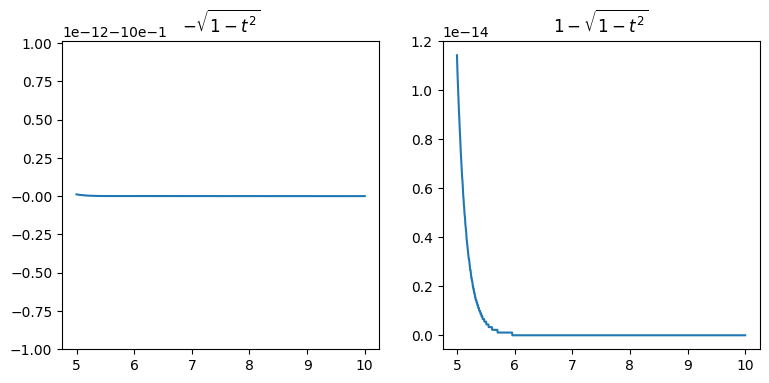

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
t = np.exp(-np.pi*xx)
axes[0].plot(xx, -np.sqrt(1-t**2));
axes[0].set_title(r'$-\sqrt{1-t^2}$');
axes[1].plot(xx, 1-np.sqrt(1-t**2))
axes[1].set_title(r'$1-\sqrt{1-t^2}$');

In [9]:
# https://scicomp.stackexchange.com/questions/14795/how-to-avoid-catastrophic-cancellation-in-python-function
def func(x):
    t = np.exp(-np.pi*x)
    y = 1/t*(1-np.sqrt(1-t**2))
    return y

In [10]:
def func2(x):
    t = np.exp(-np.pi*x)
    y = 1/t*(1-np.sqrt(1-t**2))
    y = y * (1-np.sqrt(1-t**2)) / (1-np.sqrt(1-t**2))
    return y

/tmp/ipykernel_127308/1188341579.py:4: RuntimeWarning: invalid value encountered in divide
  y = y * (1-np.sqrt(1-t**2)) / (1-np.sqrt(1-t**2))


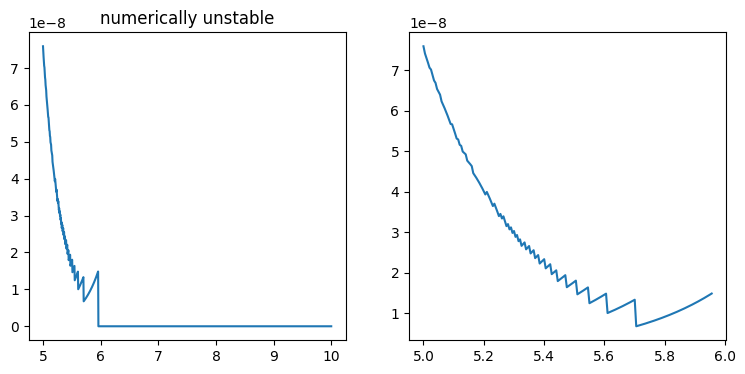

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
axes[0].plot(xx, func(xx))
axes[0].set_title("numerically unstable")
axes[1].plot(xx, func2(xx));

Now, we will transfer the function to numerically stable one:

$$f(x) = \frac{1-\sqrt{1-t^2}}{t} \times  \frac{1+\sqrt{1-t^2}}{1+\sqrt{1-t^2}} = \frac{t}{1+ \sqrt{1-t^2}} $$

In [21]:
def func3(x):
     t = np.exp(-np.pi*x)
     y = t/(1+np.sqrt(1-t**2))
     return y

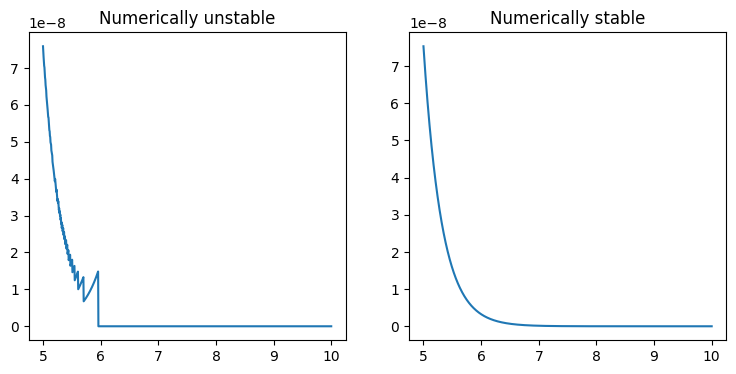

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
xx = np.linspace(5, 10, 1000)
axes[0].plot(xx, func(xx))
axes[0].set_title("Numerically unstable")
axes[1].plot(xx, func3(xx))
axes[1].set_title("Numerically stable");

When two values of nearly equal magnitude are subtracted, significant digits are lost. 
The take-away is: avoid subtraction at very small magnitude. 

## Householder Transformations

For a nonzero vector $v$, we can have the projection of $x$ onto $v$  

$$\text{proj}_v (x)= \frac{v}{||v||^2} <v, x>$$

We define $x$'s residual as the projection of $x$ onto $v^{\perp}$

$$\text{proj}_{v^{\perp}}(x) = x - \text{proj}_v (x) = x - \frac{v}{||v||^2} <v, x>$$

The orthogonal complement of a nonzero vector $v \in R^n$ is the set of all 
vectors $x \in R^n$ that are orthogonal to $v$, denoted 

$$v^{\perp} = \{ x\in R^n | <x, v>  =0 \} $$

A Householder transformation reflects the vector $x$ across the orthogonal 
complement $v^{\perp} $, in essence moving twice as far as the projection. 

A _Householder transformation_ is a linear transformation that reflects a vector
$x$ across the orthogonal complement $v^{\perp}$ for some special $v$. 

![householder-matrix](https://i.stack.imgur.com/wPH2K.jpg)

The matrix representation of the Householder transformation corresponding to
$v$ is given by 

$$H_v(x) = x - 2\text{proj}_v(x) =\left( I - 2 \frac{v v^T}{v^T v} \right)x $$

$$H_v = I - 2 \frac{v v^T}{v^T v}$$

## Householder Triangularization
The first step in finding a QR decomposition of a matrix is to find for each nonzero
$x \in F^n$ and nonzero $v \in F^n$ for which $H_v(x) \ in $ span($e_1$), where 
$e_1$ is the first standard basis vector of $F^n$. 

Lemma: For $x \in \mathbb{R}^n$, if $v=x+\|x\| e_1$ is nonzero, then $H_v(x)=-\|x\| e_1$, and if $v=x-\|x\| e_1$ is nonzero, then $H_v(x)=\|x\| e_1$.

Proof. The argument for the two cases is similar; we show the argument for $v=x+$ $\|x\| e_1 \neq 0$. For $x_1$ the first entry of $x$ we have
$$
\begin{aligned}
v^T v & =\left(x+\|x\| e_1\right)^T\left(x+\|x\| e_1\right) \\
& =x^T x+\|x\| x^T e_1+\|x\| e_1^T x+\|x\|^2 e_1^T e_1 \\
& =2\|x\|^2+2\|x\| x_1=2\|x\|\left(\|x\|+x_1\right),
\end{aligned}
$$
and
$$
\begin{aligned}
v v^T x & =\left(x+\|x\| e_1\right)\left(x+\|x\| e_1\right)^T x \\
& =x x^T x+\|x\| x e_1^T x+\|x\| e_1 x^T x+\|x\|^2 e_1 e_1^T x \\
& =\|x\|^2 x+\|x\| x_1 x+\|x\|^3 e_1+\|x\|^2 x_1 e_1 \\
& =\|x\|\left(\|x\| x+x_1 x+\|x\|^2 e_1+\|x\| x_1 e_1\right) \\
& \left.=\|x\|\left(\|x\|+x_1\right) x+\|x\|\left(\|x\|+x_1\right) e_1\right) \\
& =\|x\|\left(\|x\|+x_1\right)\left(x+\|x\| e_1\right) .
\end{aligned}
$$
Then
$$
\begin{aligned}
H_v(x) & =x-2 \frac{v v^T x}{v^T v} \\
& =x-2 \frac{\|x\|\left(\|x\|+x_1\right)\left(x+\|x\| e_1\right)}{2\|x\|\left(\|x\|+x_1\right)} \\
& =x-\left(x+\|x\| e_1\right) \\
& =-\|x\| e_1 .
\end{aligned}
$$

Now, we will use an example to calcuate

- $v = x - ||x|| e_1$
- $H_v(x)$

The purpose of doing this is to give you some feelings how those two functions
could give us an upper triangular matrix. 

In [19]:
A = np.array(
    [
        [1, -1, 4],
        [1, 4, -2],
        [1, 4, 2],
        [1, -1, 0]
    ]
)
A

array([[ 1, -1,  4],
       [ 1,  4, -2],
       [ 1,  4,  2],
       [ 1, -1,  0]])

In [20]:
Q, R = modified_gram_schmidt(A)
Q

array([[ 0.5, -0.5,  0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5]])

In [21]:
R

array([[ 2.,  3.,  2.],
       [ 0.,  5., -2.],
       [ 0.,  0.,  4.],
       [ 0.,  0.,  0.]])

In [28]:
# calcualte householder transformation manualy: step 1- projection on basis 
e1 = np.array(
    [
        [1],
        [0], 
        [0],
        [0]
    ]
)
v1 = A[:, 0].reshape(4, 1) - np.sign(A[0, 0]) * np.linalg.norm(A[:, 0]) * e1
v1

array([[-1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [30]:
# calculate householder transformation manualy: step 1- projection on v'
ai = np.eye(A[:, 0].shape[0])
ai

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [34]:
vvt = (v1 @ v1.T)/(v1.T @ v1)

In [40]:
Hv1 = (ai - 2 * vvt) 
Hv1

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

In [41]:
Hv1 @ A

array([[ 2.,  3.,  2.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  4.],
       [ 0., -5.,  2.]])

Notice that the first column of $H_{v1}A$ is a positive scalar 
multiple of $e_1$. 

In [25]:
np.sign(A[0, 0]) * np.linalg.norm(A[:, 0]) * e1

array([[2.],
       [0.],
       [0.],
       [0.]])

The geometric intuition is that we are doing projection first and then reflection. 
We have already shown that $H_{v_1}A$ has the form

$$
\begin{bmatrix}
* & * & * & \cdots & * \\
0 & * & * & \cdots & * \\
0 & * & * & \cdots & * \\ 
\vdots & \vdots & \vdots &  \ddots & \vdots \\
0 & * & * & \cdots & * 
\end{bmatrix}
$$

Now we will show how we will use 

- $v = x - ||x|| e_i$
- $H_v(x)$

To construct the matrix $R$ successively. 

With the above matrix, we decompose $x_2$ into $x_2 = x_2' + x_2''$, where $x_2'$ 
and $x_2''$ are of the form 

$$
x_1' = \begin{bmatrix}
z_1 \\
0 \\ 
\vdots \\ 
0 
\end{bmatrix}, \quad x_2'' = \begin{bmatrix}
0 \\
z_2 \\ 
\vdots \\ 
z_m
\end{bmatrix}
$$

_Remark_: $x_2'$ and $x_2''$ are orthogonal. 

For instance, if we have $H_{v_1}A$ as follows 

$$
H_{v_1}A = \begin{bmatrix}
2 &   3 & 2 \\
0 &  0 &  0 \\
0 &  0 &   4 \\
0 & -5 & 2 
\end{bmatrix}
$$

We can consider the second column $x_2$ of $H_{v_1}A$ wihich can be written as 

$$
x_2 = x_2'+ x_2' = \begin{bmatrix}
  3\\
  0\\
  0\\
  0\\ \end{bmatrix} + \begin{bmatrix}
  0\\
  0\\
  0\\
  -5 \end{bmatrix}
$$

Notice that $x_2' \in $ span($\{e_1\}$) and $x_2'' \in$ span($\{e_1^{\perp}\}$).
And be aware $\{e_1^{\perp}\}$ is a set (in fact a whole subspace)-not a vector. 

Then we will construct $H_{v_2}$ with $x_2''$. 

Repeat the above calculation for other columns will lead us to $R$. 

Let's summarize we have done:

- we want to do QR decomposition
    - we found tools that could help us: Householder reflection
    - In householder reflection, we need an arbitray vector $v$ 
    - How could we find this vector $v$ (we use basis)
    - however, we will use the vector that is orthogal to $x_1$ (or it could be $x_i$)
    intead of $e_1$. 
    - After constructing $v_1$, then we will do projection, this will make sure
    all columns will be projected onto $v_1$ and we could calcualte the coefficient,
    meanwhile the projectin of $x_1$ onto $v_1$ will have zeros in all but the
    first entry. 
- we also want to avoid subtraction
    - how could we do it then?

We have already shown: For $x \in \mathbb{R}^n$, if $v=x+\|x\| e_1$ is nonzero, then $H_v(x)=-\|x\| e_1$, and if $v=x-\|x\| e_1$ is nonzero, then $H_v(x)=\|x\| e_1$.

This means that cossing $v = x + \text{sign}(x_i) ||x|| e_1$ implies that

$$H_v(x) = -\text{sign}(x_1)||x|| e_1$$

Now, we will write our algorithm with the following formula (avoding minus):

- $v = x + \text{sign}(x_1) ||x|| e_1$
- $H_v(x) = ||x|| e_1$

Every time we have $H_v$ we can update $Q, R$ as follows

$$R = H_v A, \quad Q = QH_v$$

Where $H = I - 2v v^T$

In [131]:
def householder_qr(A:np.ndarray) -> np.ndarray:
    """
    Doing QR decomposition via householder transformation 
        assuming n <= m or Rank(A) = n <= m 
    """
    m, n = A.shape
    # convert to float64 incase inputs are integer
    R = A.copy().astype(np.float64)  
    Q = np.eye(m)
    # construct sign function
    sign = lambda x: 1 if x >= 0 else -1
    # iterate over columns 
    for i in range(n):
        # get the column and reshape it into column vector 
        # it is important to copy 
        # as matrix is mutable in numpy 
        x = R[i:, i].reshape(-1, 1).copy()
        # calculate the column
        x_norm = np.linalg.norm(x)
        # update the first entry 
        x[0, 0] = x[0, 0] + sign(x[0,0]) * x_norm
        # normalize the vector
        x /= np.linalg.norm(x)

        # update R and Q
        R[i:, i:] = R[i:, i:] - 2 * x @ x.T @ R[i:, i:] 
        Q[i:, :] = Q[i:, :] - 2 * x @ x.T @ Q[i:, :]

    # transpose Q 
    return Q.T, R 

For the above function, we need to add a little bit explanation:

- at line 17, we need to copy as array is mutable in numpy
- at line 21, we only update the first entry as 

$$
v_i = x_i + \text{sign} ||x_i|| e1 = \begin{bmatrix}
  1\\
  2\\
  3\\
  4\\
\end{bmatrix} + \text{sign} ||x_i|| \begin{bmatrix}
  1\\
  0\\
  0\\
  0
\end{bmatrix}
$$

- at line 21, if you change it to $x_{11} - \text{sign}(x_{11}) ||x_i||$, the sign
of $Q$ and $R$ will change too. But $QR = A$ is still the case.

- for lines 25, 26, we updated based on $R = H_v A, \quad Q = QH_v$, $H = I - 2v v^T$
(note $v$ is normalized in our code, meaning $v^Tv = 1$ ). 

In [139]:
A = np.array(
    [
        [1, -1, 4],
        [1, 4, -2],
        [1, 4, 2],
        [1, -1, 0]
    ]
)
A

array([[ 1, -1,  4],
       [ 1,  4, -2],
       [ 1,  4,  2],
       [ 1, -1,  0]])

In [140]:
Q, R = sp.linalg.qr(A)

In [141]:
Q

array([[-0.5,  0.5, -0.5, -0.5],
       [-0.5, -0.5,  0.5, -0.5],
       [-0.5, -0.5, -0.5,  0.5],
       [-0.5,  0.5,  0.5,  0.5]])

In [142]:
R

array([[-2., -3., -2.],
       [ 0., -5.,  2.],
       [ 0.,  0., -4.],
       [ 0.,  0.,  0.]])

In [132]:
Q, R = householder_qr(A)

In [133]:
Q

array([[-0.5,  0.5, -0.5, -0.5],
       [-0.5, -0.5,  0.5, -0.5],
       [-0.5, -0.5, -0.5,  0.5],
       [-0.5,  0.5,  0.5,  0.5]])

In [135]:
R

array([[-2.00000000e+00, -3.00000000e+00, -2.00000000e+00],
       [-2.22044605e-16, -5.00000000e+00,  2.00000000e+00],
       [-2.22044605e-16,  8.88178420e-16, -4.00000000e+00],
       [-2.22044605e-16, -2.22044605e-16,  0.00000000e+00]])

Notice that householder transformation could compute $R$ in 15 decimals, 
which means it is perseves the magnitude well.  

In [134]:
R.round(3)

array([[-2., -3., -2.],
       [-0., -5.,  2.],
       [-0.,  0., -4.],
       [-0., -0.,  0.]])

In [125]:
(Q @ R).round(3)

array([[ 1., -1.,  4.],
       [ 1.,  4., -2.],
       [ 1.,  4.,  2.],
       [ 1., -1.,  0.]])

In [113]:
Q, R = modified_gram_schmidt(A)
Q

array([[ 0.5, -0.5,  0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5]])

In [114]:
R

array([[ 2.,  3.,  2.],
       [ 0.,  5., -2.],
       [ 0.,  0.,  4.],
       [ 0.,  0.,  0.]])

In [151]:
A = np.random.random((4, 4))
Q, R = sp.linalg.qr(A)
R

array([[-1.49625203, -0.78137163, -0.98183012, -0.96781874],
       [ 0.        ,  0.8860711 , -0.13838733,  0.14871231],
       [ 0.        ,  0.        , -0.41104328, -0.20541953],
       [ 0.        ,  0.        ,  0.        , -0.0970353 ]])

In [147]:
Q

array([[-0.4498757 ,  0.4229769 ,  0.66323422, -0.4228744 ],
       [-0.33704763, -0.61761877,  0.49210655,  0.51261787],
       [-0.3805877 , -0.57841446, -0.30591272, -0.65345782],
       [-0.7342777 ,  0.32415167, -0.47367596,  0.36248178]])

In [152]:
np.allclose(Q @ R, A)

True

In [153]:
Q, R = householder_qr(A)
R.round(8)

array([[-1.49625203, -0.78137163, -0.98183012, -0.96781874],
       [ 0.        ,  0.8860711 , -0.13838733,  0.14871231],
       [ 0.        ,  0.        , -0.41104328, -0.20541953],
       [ 0.        ,  0.        , -0.        ,  0.0970353 ]])

In [154]:
Q

array([[-0.11325251,  0.94943543, -0.21852495, -0.19491815],
       [-0.58262612,  0.05922812, -0.15106478,  0.79637821],
       [-0.63373669, -0.29480599, -0.47761089, -0.53231106],
       [-0.49608313,  0.09029854,  0.83744499, -0.21079275]])

In [155]:
np.allclose(Q @ R, A)

True

## Upper Hessenberg Form 

In [137]:
A = np.random.random((4, 4))
H, Q = sp.linalg.hessenberg(A, calc_q=True)
H

array([[ 0.21546573, -1.10314036,  0.05557907,  0.21239038],
       [-1.03211547,  0.70840189, -0.22862707, -0.24182012],
       [ 0.        , -0.33012182,  0.11259881,  0.22216525],
       [ 0.        ,  0.        , -0.10820133, -0.09491412]])

In [138]:
Q

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.63006599,  0.60985889, -0.48071715],
       [ 0.        , -0.75609701, -0.62291002,  0.20074965],
       [ 0.        , -0.17701457,  0.48995432,  0.8535869 ]])

In [2]:
def hessenberg(A):
    """
    Hessenberg decomposition 
    """
    m, n = A.shape
    # convert to float64 incase inputs are integer
    H = A.copy().astype(np.float64)  
    Q = np.eye(m)
    # construct sign function
    sign = lambda x: 1 if x >= 0 else -1
    # iterate over columns 
    for i in range(n-2):
        # get the column and reshape it into column vector 
        # it is important to copy 
        # as matrix is mutable in numpy 
        x = H[i+1:, i].reshape(-1, 1).copy()
        # calculate the column
        x_norm = np.linalg.norm(x)
        # update the first entry 
        x[0, 0] = x[0, 0] + sign(x[0,0]) * x_norm
        # normalize the vector
        x /= np.linalg.norm(x)

        # update H and Q
        H[i+1:, i:] = H[i+1:, i:] - 2 * x @ x.T @ H[i+1:, i:] 
        H[:, i+1:] = H[:, i+1:] - 2 * (H[:, i+1:] @ x) @ x.T 
        Q[i+1:, :] = Q[i+1:, :] - 2 * x @ x.T @ Q[i+1:, :]

    # transpose Q 
    return H, Q.T

In [13]:
A = np.random.random((4,4))
H, Q = sp.linalg.hessenberg(A, calc_q=True)

In [8]:
H

array([[ 0.21741081, -1.08784147,  0.89280602, -0.11020534],
       [-0.83934132,  1.32932107, -0.37462398,  0.41012648],
       [ 0.        , -0.70370259,  0.22943654,  0.81205142],
       [ 0.        ,  0.        , -0.18468521,  0.19362845]])

In [14]:
Q 

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.30075319,  0.95367558,  0.00710008],
       [ 0.        , -0.80382515, -0.24947556, -0.54002506],
       [ 0.        , -0.51323742, -0.16812148,  0.84161899]])

In [15]:
H, Q = hessenberg(A)

In [12]:
np.round(H, 7)

array([[ 0.2174108, -1.0878415,  0.892806 , -0.1102053],
       [-0.8393413,  1.3293211, -0.374624 ,  0.4101265],
       [-0.       , -0.7037026,  0.2294365,  0.8120514],
       [-0.       ,  0.       , -0.1846852,  0.1936285]])

In [16]:
Q 

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.30075319,  0.95367558,  0.00710008],
       [ 0.        , -0.80382515, -0.24947556, -0.54002506],
       [ 0.        , -0.51323742, -0.16812148,  0.84161899]])